In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pathlib

In [2]:
import torchvision.models as models
import torch
from torchsummary import summary

In [3]:
single_img = plt.imread("/kaggle/input/data/images_001/images/00000001_000.png")

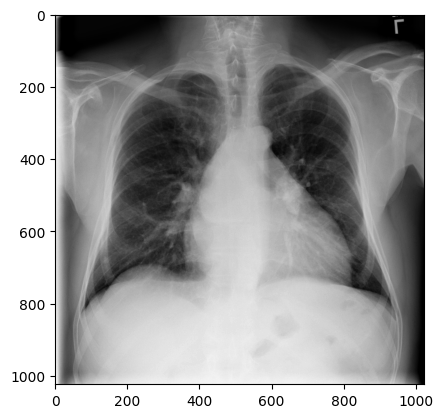

In [4]:
plt.imshow(single_img, cmap="gray")

In [5]:
data = pd.read_csv("/kaggle/input/data/Data_Entry_2017.csv")

In [6]:
data

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN


In [7]:
all_columns =list(data.columns)

In [8]:
all_columns

['Image Index',
 'Finding Labels',
 'Follow-up #',
 'Patient ID',
 'Patient Age',
 'Patient Gender',
 'View Position',
 'OriginalImage[Width',
 'Height]',
 'OriginalImagePixelSpacing[x',
 'y]',
 'Unnamed: 11']

In [9]:
useful_columns = all_columns[0:2]+all_columns[7:11]

In [10]:
useful_columns

['Image Index',
 'Finding Labels',
 'OriginalImage[Width',
 'Height]',
 'OriginalImagePixelSpacing[x',
 'y]']

In [11]:
useful_data = data[useful_columns]

In [12]:
path_list = list()
file_names = list()
for absolute_path in pathlib.Path("/kaggle/input/data").glob("images_*/images/*.png"):
    
    path_list.append(str(absolute_path))                
    file_names.append(str(absolute_path).split("/")[-1])

In [13]:
path_list.sort()

In [14]:
path_list

['/kaggle/input/data/images_001/images/00000001_000.png',
 '/kaggle/input/data/images_001/images/00000001_001.png',
 '/kaggle/input/data/images_001/images/00000001_002.png',
 '/kaggle/input/data/images_001/images/00000002_000.png',
 '/kaggle/input/data/images_001/images/00000003_000.png',
 '/kaggle/input/data/images_001/images/00000003_001.png',
 '/kaggle/input/data/images_001/images/00000003_002.png',
 '/kaggle/input/data/images_001/images/00000003_003.png',
 '/kaggle/input/data/images_001/images/00000003_004.png',
 '/kaggle/input/data/images_001/images/00000003_005.png',
 '/kaggle/input/data/images_001/images/00000003_006.png',
 '/kaggle/input/data/images_001/images/00000003_007.png',
 '/kaggle/input/data/images_001/images/00000004_000.png',
 '/kaggle/input/data/images_001/images/00000005_000.png',
 '/kaggle/input/data/images_001/images/00000005_001.png',
 '/kaggle/input/data/images_001/images/00000005_002.png',
 '/kaggle/input/data/images_001/images/00000005_003.png',
 '/kaggle/inpu

In [15]:
useful_data["Image Path"]= path_list

/tmp/ipykernel_19/2806891288.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  useful_data["Image Path"]= path_list


In [16]:
useful_data

,Image Index,Finding Labels,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Image Path
0,00000001_000.png,Cardiomegaly,2682,2749,0.143,0.143,/kaggle/input/data/images_001/images/00000001_...
1,00000001_001.png,Cardiomegaly|Emphysema,2894,2729,0.143,0.143,/kaggle/input/data/images_001/images/00000001_...
2,00000001_002.png,Cardiomegaly|Effusion,2500,2048,0.168,0.168,/kaggle/input/data/images_001/images/00000001_...
3,00000002_000.png,No Finding,2500,2048,0.171,0.171,/kaggle/input/data/images_001/images/00000002_...
4,00000003_000.png,Hernia,2582,2991,0.143,0.143,/kaggle/input/data/images_001/images/00000003_...
...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,2048,2500,0.168,0.168,/kaggle/input/data/images_012/images/00030801_...
112116,00030802_000.png,No Finding,2048,2500,0.168,0.168,/kaggle/input/data/images_012/images/00030802_...
112117,00030803_000.png,No Finding,2048,2500,0.168,0.168,/kaggle/input/data/images_012/images/00030803_...
112118,00030804_000.png,No Finding,2048,2500,0.168,0.168,/kaggle/input/data/images_012/images/00030804_...


In [17]:
unique_diseases = set()

for disease in useful_data["Finding Labels"]:
    unique_diseases.update(set(disease.split("|")))

In [18]:
unique_diseases = list(unique_diseases)

In [19]:
unique_diseases.remove("No Finding")

In [20]:
unique_diseases

['Mass',
 'Pneumonia',
 'Infiltration',
 'Atelectasis',
 'Cardiomegaly',
 'Nodule',
 'Effusion',
 'Edema',
 'Pneumothorax',
 'Pleural_Thickening',
 'Emphysema',
 'Hernia',
 'Fibrosis',
 'Consolidation']

In [21]:
diseases2idx = dict(zip(unique_diseases , range(len(unique_diseases))))

In [22]:
diseases2idx

{'Mass': 0,
 'Pneumonia': 1,
 'Infiltration': 2,
 'Atelectasis': 3,
 'Cardiomegaly': 4,
 'Nodule': 5,
 'Effusion': 6,
 'Edema': 7,
 'Pneumothorax': 8,
 'Pleural_Thickening': 9,
 'Emphysema': 10,
 'Hernia': 11,
 'Fibrosis': 12,
 'Consolidation': 13}

In [23]:
another_data = pd.read_csv("/kaggle/input/data/BBox_List_2017.csv")

In [24]:
another_data

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,NaN,NaN,NaN
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
979,00029464_015.png,Atelectasis,198.940451,352.900747,615.537778,323.128889,NaN,NaN,NaN
980,00025769_001.png,Atelectasis,701.838229,572.491858,103.537778,63.715556,NaN,NaN,NaN
981,00016837_002.png,Atelectasis,140.913785,658.962969,271.928889,94.435556,NaN,NaN,NaN
982,00020124_003.png,Atelectasis,175.047118,580.456302,244.622222,103.537778,NaN,NaN,NaN


In [25]:
b_box = pd.DataFrame(another_data)

In [26]:
train_data = pd.DataFrame(useful_data)

In [27]:
columns_to_drop = b_box["Image Index"]
    

In [28]:
columns_to_drop

0      00013118_008.png
1      00014716_007.png
2      00029817_009.png
3      00014687_001.png
4      00017877_001.png
             ...       
979    00029464_015.png
980    00025769_001.png
981    00016837_002.png
982    00020124_003.png
983    00026920_000.png
Name: Image Index, Length: 984, dtype: object

In [29]:
test_data = train_data[train_data['Image Index'].isin(columns_to_drop)]

In [30]:
train_data = train_data[~train_data['Image Index'].isin(columns_to_drop)]

In [31]:
test_data

,Image Index,Finding Labels,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Image Path
151,00000032_037.png,Cardiomegaly|Edema|Infiltration,2500,2048,0.168000,0.168000,/kaggle/input/data/images_001/images/00000032_...
310,00000072_000.png,Atelectasis,2450,2839,0.143000,0.143000,/kaggle/input/data/images_001/images/00000072_...
596,00000147_001.png,Atelectasis,2742,2948,0.143000,0.143000,/kaggle/input/data/images_001/images/00000147_...
608,00000149_006.png,Atelectasis,2500,2048,0.168000,0.168000,/kaggle/input/data/images_001/images/00000149_...
614,00000150_002.png,Atelectasis|Infiltration|Pneumonia,3056,2544,0.139000,0.139000,/kaggle/input/data/images_001/images/00000150_...
...,...,...,...,...,...,...,...
111704,00030606_006.png,Emphysema|Pneumothorax,2021,2021,0.194311,0.194311,/kaggle/input/data/images_012/images/00030606_...
111791,00030634_000.png,Effusion,2544,3056,0.139000,0.139000,/kaggle/input/data/images_012/images/00030634_...
111793,00030635_001.png,Atelectasis|Effusion,1798,1815,0.194314,0.194314,/kaggle/input/data/images_012/images/00030635_...
111807,00030636_004.png,Atelectasis|Infiltration,3056,2544,0.139000,0.139000,/kaggle/input/data/images_012/images/00030636_...


In [32]:
train_data

,Image Index,Finding Labels,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Image Path
0,00000001_000.png,Cardiomegaly,2682,2749,0.143,0.143,/kaggle/input/data/images_001/images/00000001_...
1,00000001_001.png,Cardiomegaly|Emphysema,2894,2729,0.143,0.143,/kaggle/input/data/images_001/images/00000001_...
2,00000001_002.png,Cardiomegaly|Effusion,2500,2048,0.168,0.168,/kaggle/input/data/images_001/images/00000001_...
3,00000002_000.png,No Finding,2500,2048,0.171,0.171,/kaggle/input/data/images_001/images/00000002_...
4,00000003_000.png,Hernia,2582,2991,0.143,0.143,/kaggle/input/data/images_001/images/00000003_...
...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,2048,2500,0.168,0.168,/kaggle/input/data/images_012/images/00030801_...
112116,00030802_000.png,No Finding,2048,2500,0.168,0.168,/kaggle/input/data/images_012/images/00030802_...
112117,00030803_000.png,No Finding,2048,2500,0.168,0.168,/kaggle/input/data/images_012/images/00030803_...
112118,00030804_000.png,No Finding,2048,2500,0.168,0.168,/kaggle/input/data/images_012/images/00030804_...


In [33]:
y_train =  train_data["Finding Labels"]

In [34]:
y_train


0                   Cardiomegaly
1         Cardiomegaly|Emphysema
2          Cardiomegaly|Effusion
3                     No Finding
4                         Hernia
                   ...          
112115            Mass|Pneumonia
112116                No Finding
112117                No Finding
112118                No Finding
112119                No Finding
Name: Finding Labels, Length: 111240, dtype: object

In [35]:
y_train =list()
for single_img_labels in train_data["Finding Labels"]:
    single_img_multi_hot_vector = np.zeros((len(diseases2idx,)))
    diseases = single_img_labels.split("|")
    if "No Finding" not in diseases:
        for single_diseases in diseases:
            single_img_multi_hot_vector[diseases2idx[single_diseases]]=1.0
    y_train.append(single_img_multi_hot_vector)
y_train = np.array(y_train)

In [36]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [37]:
y_train.shape

(111240, 14)

In [38]:
y_test =list()
for single_img_labels in test_data["Finding Labels"]:
    single_img_multi_hot_vector = np.zeros((len(diseases2idx,)))
    diseases = single_img_labels.split("|")
    if "No Finding" not in diseases:
        for single_diseases in diseases:
            single_img_multi_hot_vector[diseases2idx[single_diseases]]=1.0
    y_test.append(single_img_multi_hot_vector)
y_test = np.array(y_test)

In [39]:
y_test

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [40]:
y_test.shape

(880, 14)

In [41]:
def training_data_mini_batches_generator(training_data_df, mb_size=10):
    
    for i in range (training_data_df.shape[0]//mb_size):

        img_np_array_mb_list = list()
        
        for j in range(i*mb_size,(i+1)*mb_size):
            
            single_img_path  = train_data["Image Path"].iloc[j]
            img_np_array = plt.imread(single_img_path)

            resized_img_np_array = cv2.resize(img_np_array,(224,224))
            if len(resized_img_np_array.shape) == 2 or resized_img_np_array.shape[2] == 1:
            # grayscale image (H, W) or (H, W, 1)
                three_channel_np_array = cv2.cvtColor(resized_img_np_array, cv2.COLOR_GRAY2RGB)
            elif resized_img_np_array.shape[2] == 4:
            # image with 4 channels (e.g., RGBA) → drop alpha
                three_channel_np_array = resized_img_np_array[:, :, :3]
            else:
            # already 3 channels
                three_channel_np_array = resized_img_np_array

            img_np_array_mb_list.append(three_channel_np_array)

        x_train_mb = np.array(img_np_array_mb_list)
        y_train_mb = y_train[i*mb_size:(i+1)*mb_size,:]

        yield x_train_mb,y_train_mb
        

In [42]:
our_training_datagen = training_data_mini_batches_generator(train_data)

In [43]:
X_train_mb , y_train_mb = our_training_datagen.__next__()

In [44]:
class our_custom_resnet50_cnn(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.resnet50_full_net = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

        for param in self.resnet50_full_net.parameters():
            param.requires_grad = False

        self.resnet50_full_net.fc = torch.nn.Sequential(
            torch.nn.Linear(self.resnet50_full_net.fc.in_features, num_classes),
            torch.nn.Sigmoid()  
        )

    def forward(self, x):
        
        y_pred_mb =  self.resnet50_full_net(x)
        return y_pred_mb

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [46]:
our_model = our_custom_resnet50_cnn(num_classes=14)
our_model = our_model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s]


In [47]:
summary(our_model, input_size = (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [48]:
test_data

,Image Index,Finding Labels,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Image Path
151,00000032_037.png,Cardiomegaly|Edema|Infiltration,2500,2048,0.168000,0.168000,/kaggle/input/data/images_001/images/00000032_...
310,00000072_000.png,Atelectasis,2450,2839,0.143000,0.143000,/kaggle/input/data/images_001/images/00000072_...
596,00000147_001.png,Atelectasis,2742,2948,0.143000,0.143000,/kaggle/input/data/images_001/images/00000147_...
608,00000149_006.png,Atelectasis,2500,2048,0.168000,0.168000,/kaggle/input/data/images_001/images/00000149_...
614,00000150_002.png,Atelectasis|Infiltration|Pneumonia,3056,2544,0.139000,0.139000,/kaggle/input/data/images_001/images/00000150_...
...,...,...,...,...,...,...,...
111704,00030606_006.png,Emphysema|Pneumothorax,2021,2021,0.194311,0.194311,/kaggle/input/data/images_012/images/00030606_...
111791,00030634_000.png,Effusion,2544,3056,0.139000,0.139000,/kaggle/input/data/images_012/images/00030634_...
111793,00030635_001.png,Atelectasis|Effusion,1798,1815,0.194314,0.194314,/kaggle/input/data/images_012/images/00030635_...
111807,00030636_004.png,Atelectasis|Infiltration,3056,2544,0.139000,0.139000,/kaggle/input/data/images_012/images/00030636_...


In [49]:
def test_data_mini_batches_generator(test_data_df, mb_size=10):
    for i in range(test_data_df.shape[0] // mb_size):
        img_mb_list = []
        meta_mb_list = []

        for j in range(i * mb_size, (i + 1) * mb_size):
            # Image path & loading
            img_path = test_data_df["Image Path"].iloc[j]
            img = plt.imread(img_path)

            # Original size
            ow = test_data_df["OriginalImage[Width"].iloc[j]
            oh = test_data_df["Height]"].iloc[j]
            spacing_x = test_data_df["OriginalImagePixelSpacing[x"].iloc[j]
            spacing_y = test_data_df["y]"].iloc[j]

            # Resize
            img_resized = cv2.resize(img, (224, 224))
            img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)
            img_rgb = img_rgb.transpose((2, 0, 1))  # CHW format

            # Scale spacings
            scaled_spacing_x = (ow / 224) * spacing_x
            scaled_spacing_y = (oh / 224) * spacing_y

            img_mb_list.append(img_rgb)
            meta_mb_list.append([scaled_spacing_x, scaled_spacing_y])

        # Convert to tensors
        x_img_mb = np.array(img_mb_list).astype(np.float32) / 255.0
        x_meta_mb = np.array(meta_mb_list).astype(np.float32)
        y_mb = y_test[i * mb_size:(i + 1) * mb_size, :]

        yield (x_img_mb, x_meta_mb), y_mb


In [50]:
our_testing_datagen = test_data_mini_batches_generator(test_data)

In [51]:
X_test_mb , y_test_mb = our_testing_datagen.__next__()

In [52]:
X_test_mb

(array([[[[2.1789108e-04, 2.0321854e-04, 1.9992310e-04, ...,
           8.0753869e-04, 7.2609435e-04, 6.8725529e-04],
          [2.0753399e-04, 1.9992310e-04, 1.8454441e-04, ...,
           9.5779495e-04, 8.5547945e-04, 7.9859397e-04],
          [2.0408163e-04, 1.9992310e-04, 1.8454441e-04, ...,
           9.2703744e-04, 1.0275483e-03, 9.2640979e-04],
          ...,
          [2.1563137e-03, 2.2463889e-03, 2.2893080e-03, ...,
           1.3950680e-04, 1.6406563e-04, 1.8783985e-04],
          [2.1990759e-03, 2.2696923e-03, 2.3217914e-03, ...,
           1.3950680e-04, 1.6916571e-04, 1.8995834e-04],
          [2.3057067e-03, 2.3562368e-03, 2.4177514e-03, ...,
           1.5378701e-04, 1.7905202e-04, 2.0651399e-04]],
 
         [[2.1789108e-04, 2.0321854e-04, 1.9992310e-04, ...,
           8.0753869e-04, 7.2609435e-04, 6.8725529e-04],
          [2.0753399e-04, 1.9992310e-04, 1.8454441e-04, ...,
           9.5779495e-04, 8.5547945e-04, 7.9859397e-04],
          [2.0408163e-04, 1.9992310e-0

In [53]:
loss_func = torch.nn.BCELoss()
optimizer = torch.optim.SGD(params = our_model.parameters(),lr=0.001)
epochs = 5
mb_size = 10

for i in range(epochs):

    our_training_data_gen = training_data_mini_batches_generator(train_data)
    
    for x_train_mb,y_train_mb in our_training_data_gen:

        x_train_mb = torch.tensor(x_train_mb, dtype=torch.float32).permute(0, 3, 1, 2).to(device)  # Numpy -> Tensor + channel-first
        y_train_mb = torch.tensor(y_train_mb, dtype=torch.float32).to(device)


        y_pred_mb_train = our_model(x_train_mb)
        training_mb_loss = loss_func(y_pred_mb_train,y_train_mb)

        training_mb_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        print("Epoch # {}, Training Loss Value = {}".format(i+1,training_mb_loss))
        

Epoch # 1, Training Loss Value = 0.7119160294532776
Epoch # 1, Training Loss Value = 0.698733389377594
Epoch # 1, Training Loss Value = 0.681445837020874
Epoch # 1, Training Loss Value = 0.6835660934448242
Epoch # 1, Training Loss Value = 0.6775199174880981
Epoch # 1, Training Loss Value = 0.663928210735321
Epoch # 1, Training Loss Value = 0.6594799757003784
Epoch # 1, Training Loss Value = 0.6586350798606873
Epoch # 1, Training Loss Value = 0.659342885017395
Epoch # 1, Training Loss Value = 0.6567378640174866
Epoch # 1, Training Loss Value = 0.6461317539215088
Epoch # 1, Training Loss Value = 0.6394855976104736
Epoch # 1, Training Loss Value = 0.6470621228218079
Epoch # 1, Training Loss Value = 0.6411949396133423
Epoch # 1, Training Loss Value = 0.6477553844451904
Epoch # 1, Training Loss Value = 0.6600133180618286
Epoch # 1, Training Loss Value = 0.6195230484008789
Epoch # 1, Training Loss Value = 0.6223386526107788
Epoch # 1, Training Loss Value = 0.6051364541053772
Epoch # 1, Train